# Trace refining a surface

The idea of trace-refining a surface is to modify an existing surface that was derived from an intensity image in such a way that it represents the border of an object in the intensity image to the highest-possible degree. This notebook illustrates how it works and what the set parameters will do to the result.

In [1]:
from napari_stress import reconstruction
from napari_stress._utils.fit_utils import _sigmoid, _function_args_to_list
import napari_process_points_and_surfaces as nppas
import napari
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit
from skimage import filters, morphology, measure
import vedo

In [2]:
viewer = napari.Viewer(ndisplay=2)

In [3]:
radius = 30

# Make a blurry sphere first
image = np.zeros([100, 100, 100])
image[50 - 30:50 + 31,
      50 - 30:50 + 31,
      50 - 30:50 + 31] = morphology.ball(radius=radius)
image = filters.gaussian(image, sigma = 5)

viewer.add_image(image, name='raw')

<Image layer 'raw' at 0x1860993c3a0>

## Surface creation

We now create a surface from this data by thresholding and marching cubes surface reconstruction:

In [4]:
labels = measure.label(image > filters.threshold_otsu(image))
viewer.add_labels(labels, visible=False)

<Labels layer 'labels' at 0x18609822ca0>

In [5]:
verts, faces, normals, values = measure.marching_cubes(labels)
surface = (verts, faces)

Inspecting the surface shows that it has a high number of vertices - it may thus be of advantage to simplify the surface a bit before proceeding:

In [6]:
surface[0].shape

(17310, 3)

In [7]:
surface_simplified = nppas.simplify_vertex_clustering(surface,voxel_size=1.5)
surface_simplified[0].shape

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(6421, 3)

In [8]:
viewer.add_surface(surface_simplified)

<Surface layer 'surface_simplified' at 0x18623bedf40>

You can see that the surface still looks very voxel-like and not like the smooth object that we see in the intensity image layer.

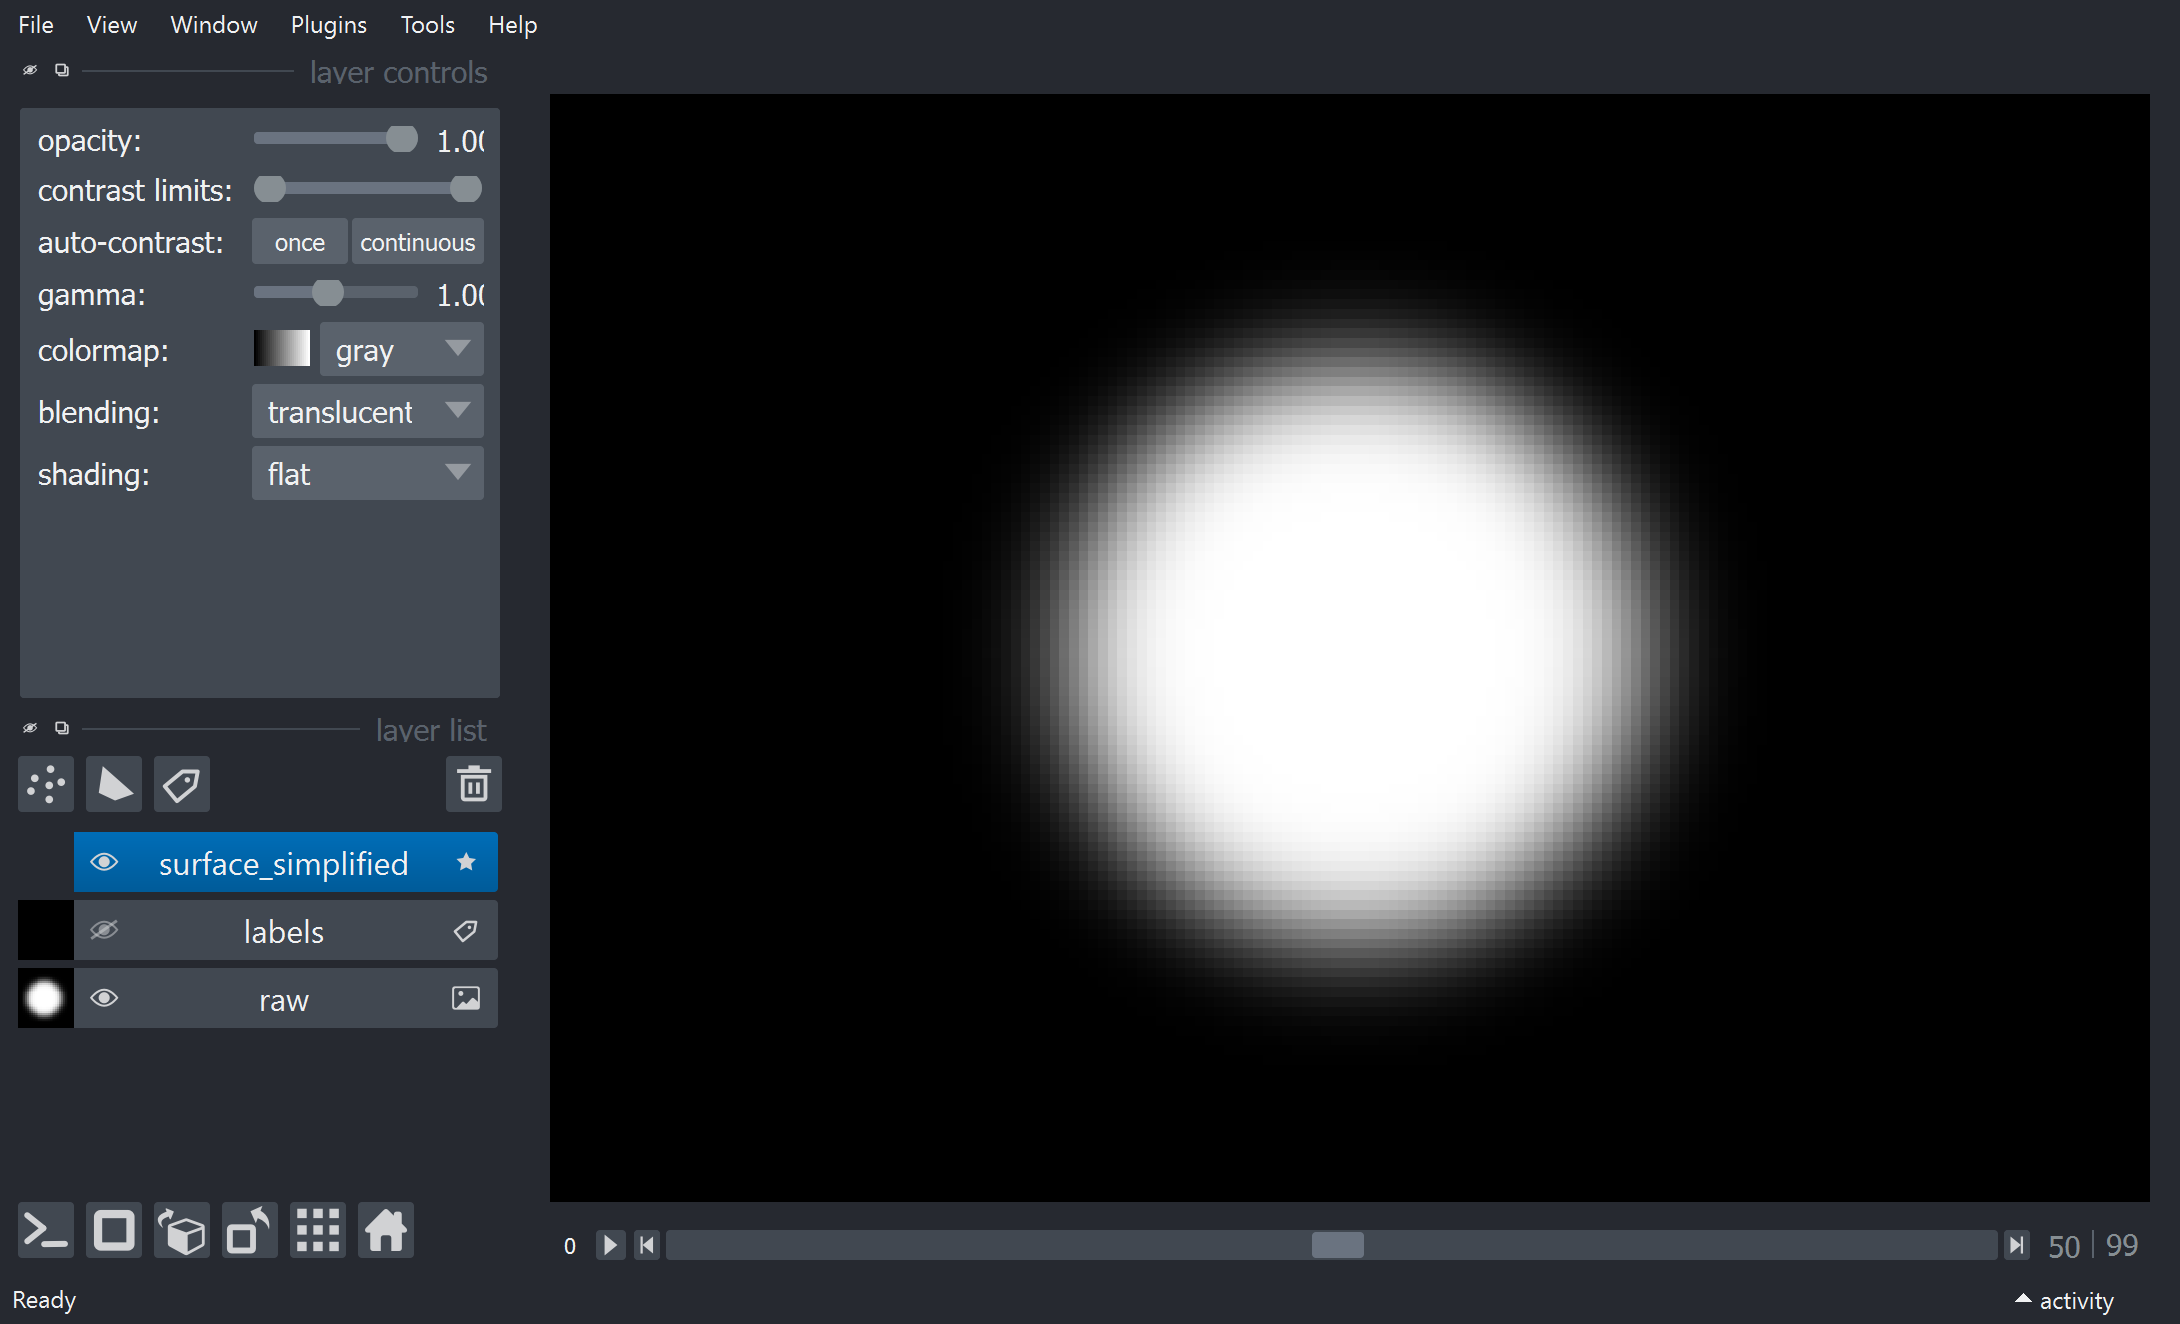

In [9]:
napari.utils.nbscreenshot(viewer)

## Creating trace vectors

To address this, we first calculate normal vectors on the surface that are multiplied by a set factor, the `trace_length` parameter. The higher this parameter, the longer the cast normal vector along the surface will be

In [10]:
trace_length = 15

In [11]:
# Convert to mesh and calculate normals
pointcloud = vedo.pointcloud.Points(surface_simplified[0])
pointcloud.computeNormalsWithPCA(orientationPoint=pointcloud.centerOfMass())

# Define start and end points for the surface tracing vectors
scale = np.asarray([1.0, 1.0, 1.0])

start_pts = pointcloud.points()/scale[None, :] - 0.5 * trace_length * pointcloud.pointdata['Normals']

# Define trace vectors for full length and for single step
vectors = trace_length * pointcloud.pointdata['Normals']

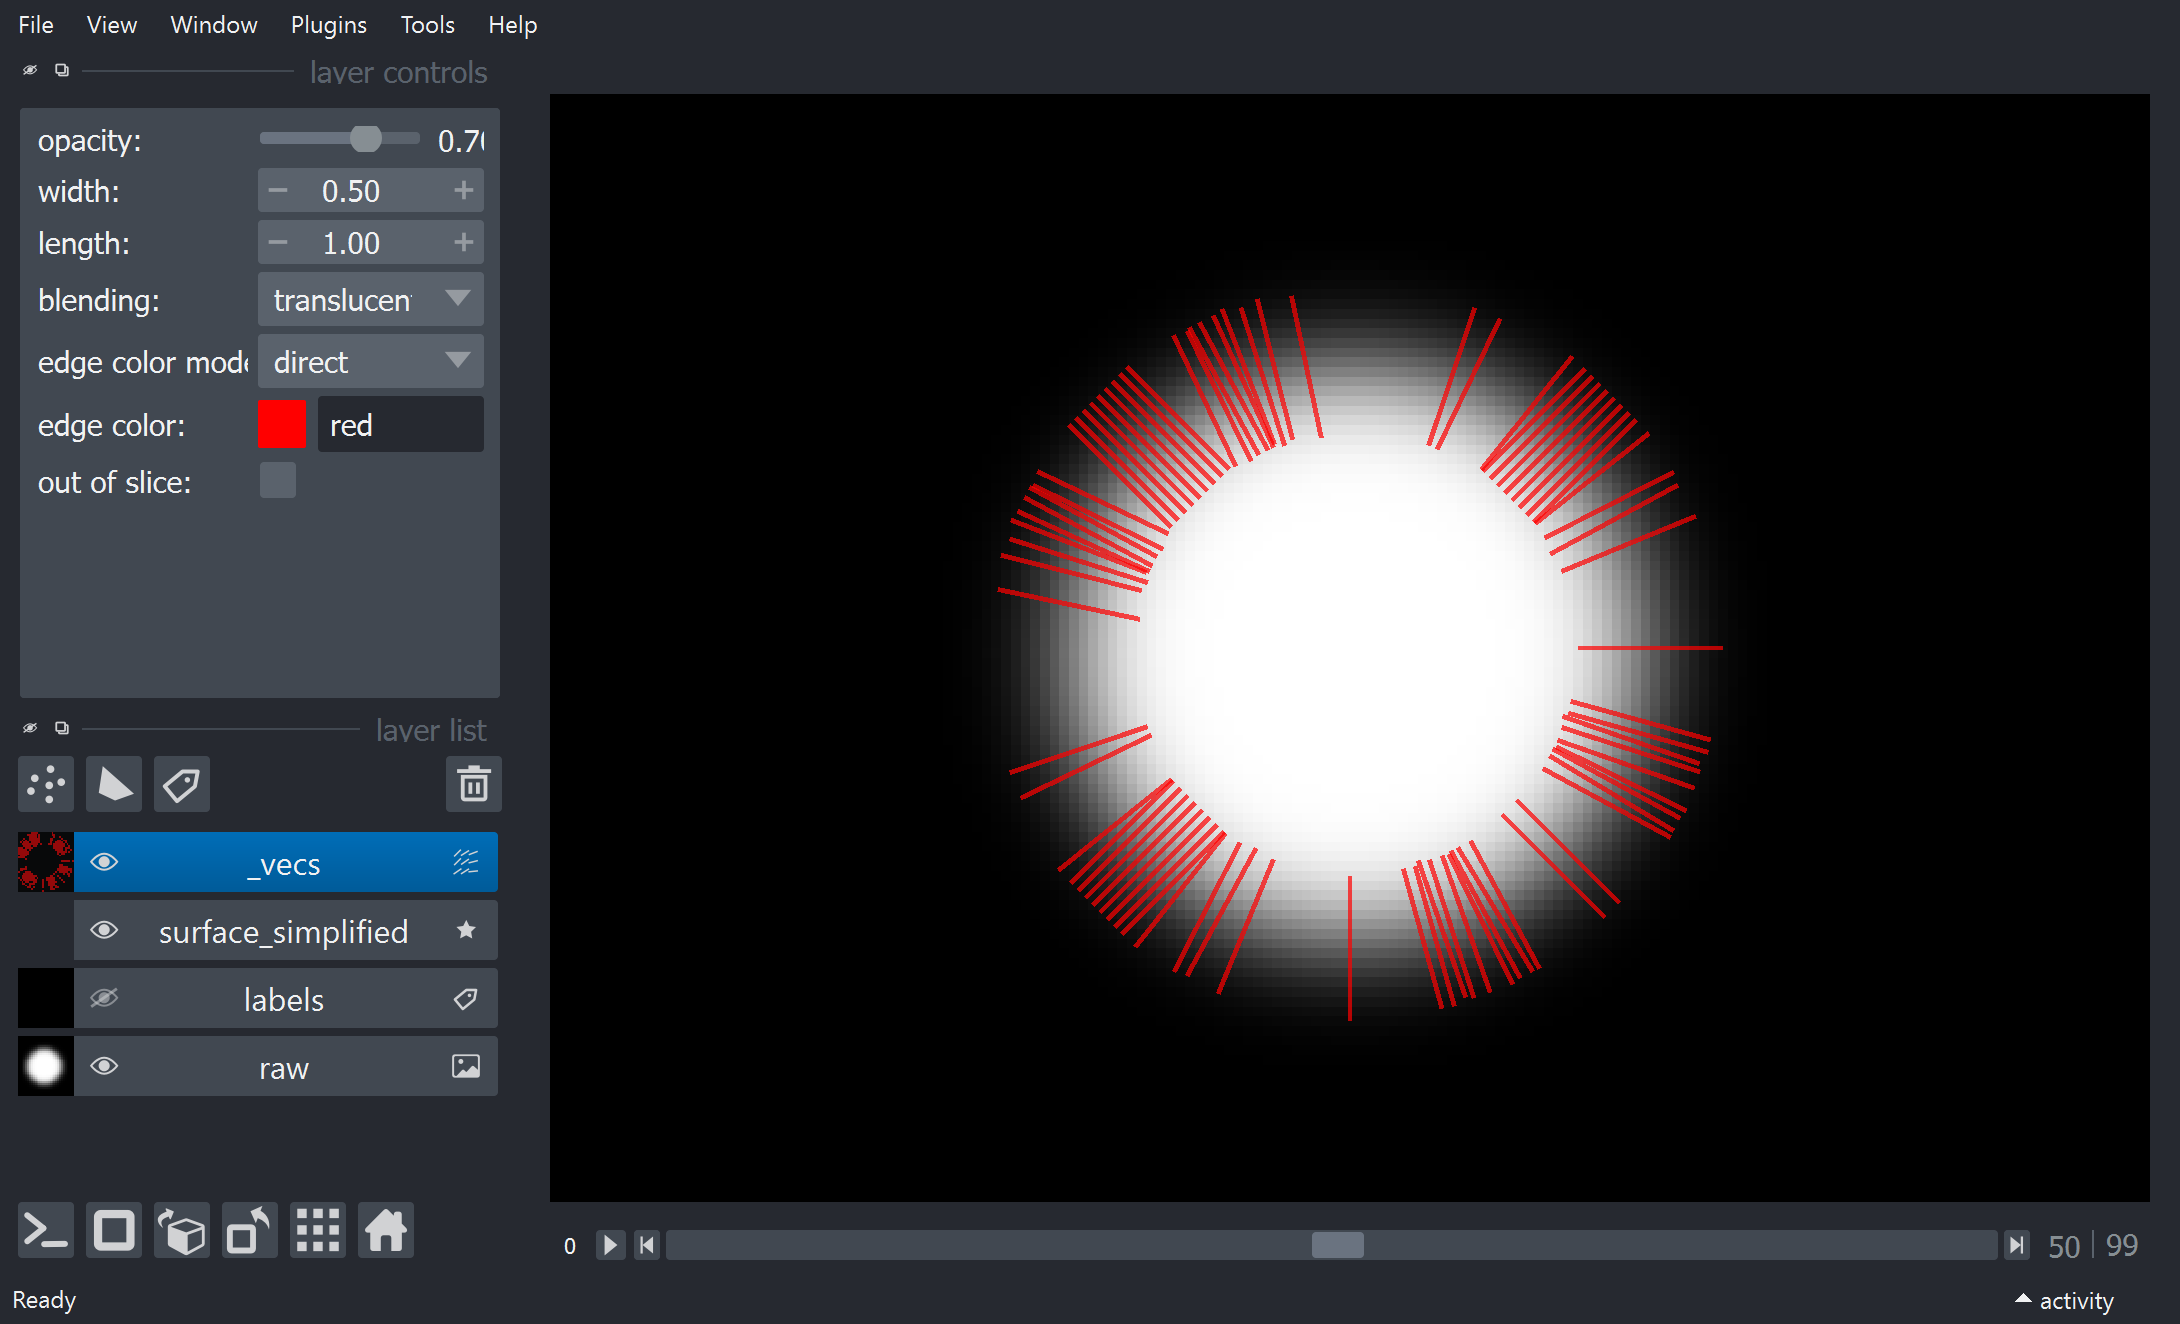

In [12]:
_vecs = np.stack([start_pts, vectors]).transpose((1,0,2))
viewer.add_vectors(_vecs, edge_width=0.5)
napari.utils.nbscreenshot(viewer)

## Measuring intensity along the normals

In order to find the "true" border of our object in the intensity image, we need to measure the intensity along each of these vectors. You can control the amount of sampled intensities along the ray using the `sampling_distance` parameter. Setting this parameter - for instance - to `sampling_distance = 1` for a normal vector of `trace_length = 10` would mean that intensity is measured 10 times along the normal with a distance of `1` between each sampled intensity. In other words: Making this parameter small, will make the following procedure more accurate, but also slower.

In [13]:
sampling_distance = 0.1

In [14]:
n_samples = int(trace_length/sampling_distance)
v_step = vectors/n_samples

In [15]:
# Create coords for interpolator and retrieve intensity values along the normal vector
X1 = np.arange(0, image.shape[0], 1)
X2 = np.arange(0, image.shape[1], 1)
X3 = np.arange(0, image.shape[2], 1)
rgi = RegularGridInterpolator((X1, X2, X3), image,
                              bounds_error=False,
                              fill_value=image.min())

profile_coords = [start_pts[0] + k * v_step[0] for k in range(n_samples)]
intensity_values = rgi(profile_coords)

Let's show the measured intensity for a given, single normal vector. 

*Note*:
- The intensity is increaing along the path of the vector because the vector is pointing towards the inside of the object!
- The shape of the curve depends on the value of `trace_length` and `sampling_distance`! Large values for `trace_length` will capture more of the intensity profile along the curve and lower values for `sampling_distance` will make the curve more smooth

Text(0.5, 0, 'Position')

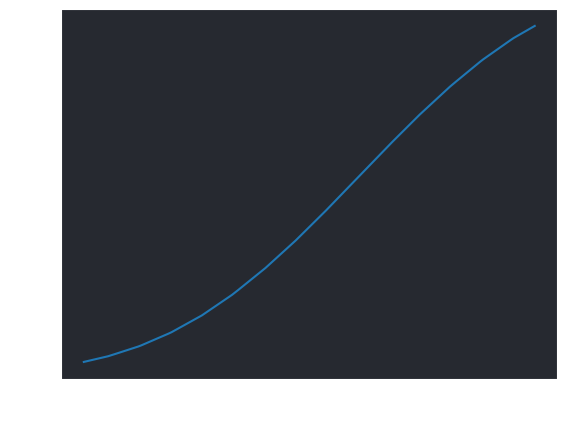

In [16]:
x = np.arange(0, trace_length, sampling_distance)
fig, ax = plt.subplots()
ax.plot(x, intensity_values)
ax.set_ylabel('Intensity')
ax.set_xlabel('Position')

## Estimate surface by fit function

In this step, we fit a given function to the intensity profile. We demonstrate this with a [sigmoidal funtion](https://en.wikipedia.org/wiki/Sigmoid_function), which is suitable to approximate the intensity of fully fluorescently labeld objects. Other fit functions (e.g., a [gaussian normal distribution](https://en.wikipedia.org/wiki/Gaussian_function)) can also deal with objects which are labelled fluorescently only on the surface.

For the fit to work, we first need to estimate some good parameters for the sigmoidal function to start with. We can have a closer look at what parameters the sigmoidal function expects:

In [17]:
_function_args_to_list(_sigmoid)

['array', 'center', 'amplitude', 'slope', 'offset']

A good estimate for these parameters could be the following:

In [18]:
# Estimate some parameters for the fit
p0 = [len(intensity_values)/2,
      max(intensity_values),
      np.diff(intensity_values).mean(),
      min(intensity_values)]
popt, _pcov = curve_fit(_sigmoid, np.arange(len(intensity_values)), intensity_values, p0)

In [19]:
print('Optimal parameters:', popt)
print('Parameter errors:', np.sqrt(np.diag(_pcov)))

Optimal parameters: [ 9.13949922e+01  1.06637033e+00  2.94673839e-02 -3.39256501e-02]
Parameter errors: [6.92631794e-02 1.81448874e-03 6.81754524e-05 6.38211393e-04]


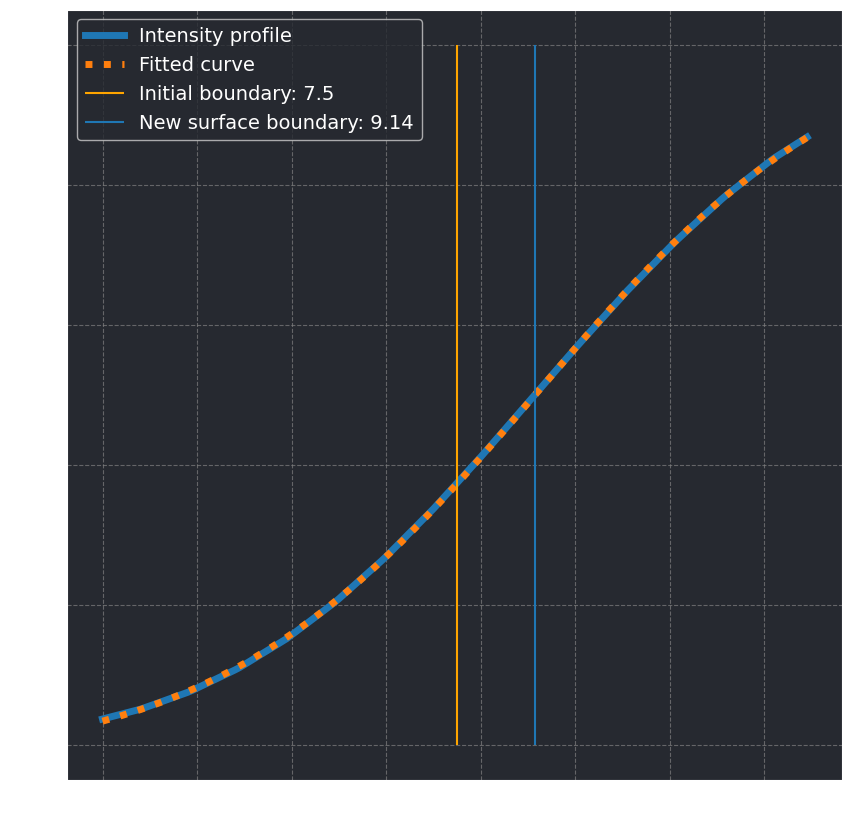

In [20]:
x = np.arange(0, trace_length, sampling_distance)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, intensity_values, linestyle = '-', linewidth=5, label = 'Intensity profile')

ax.plot(x, _sigmoid(np.arange(0, len(intensity_values), 1), *popt), linestyle = 'dotted', linewidth=5, label= 'Fitted curve')
ax.vlines(x[len(x)//2], 0, 1, label = f'Initial boundary: {x[len(x)//2]}', color='orange')
ax.vlines(sampling_distance * popt[0], 0, 1, label = 'New surface boundary: {:.2f}'.format(popt[0] * sampling_distance))

ax.legend(fontsize=14)
ax.set_ylabel('Intensity', fontsize=16)
ax.set_xlabel('Position', fontsize=16)
ax.grid(which='major', color='gray', linestyle='--', alpha=0.7)

We can now calculate the correct position for this point on the surface:

In [21]:
print('Previous point location: ', pointcloud.points()[0])
print('New point location: ', start_pts[0] + popt[0] * v_step[0])

Previous point location:  [19.5 46.5 49.5]
New point location:  [21.0943737  46.87596929 49.56764171]


## Using the implemented function

The `napari_stress.trace_refinement_of_surface()` function allows you to repeat this process for every point on the surface and filter the determined points according to the derived fit errors, if you want.

In [22]:
traced_points, trace_vectors = reconstruction.trace_refinement_of_surface(
    image, pointcloud.points(), trace_length=15, sampling_distance=0.1, show_progress=True)

Processing vertices...: 100%|█████████████████████████████████████████████████████| 6421/6421 [00:16<00:00, 379.37it/s]


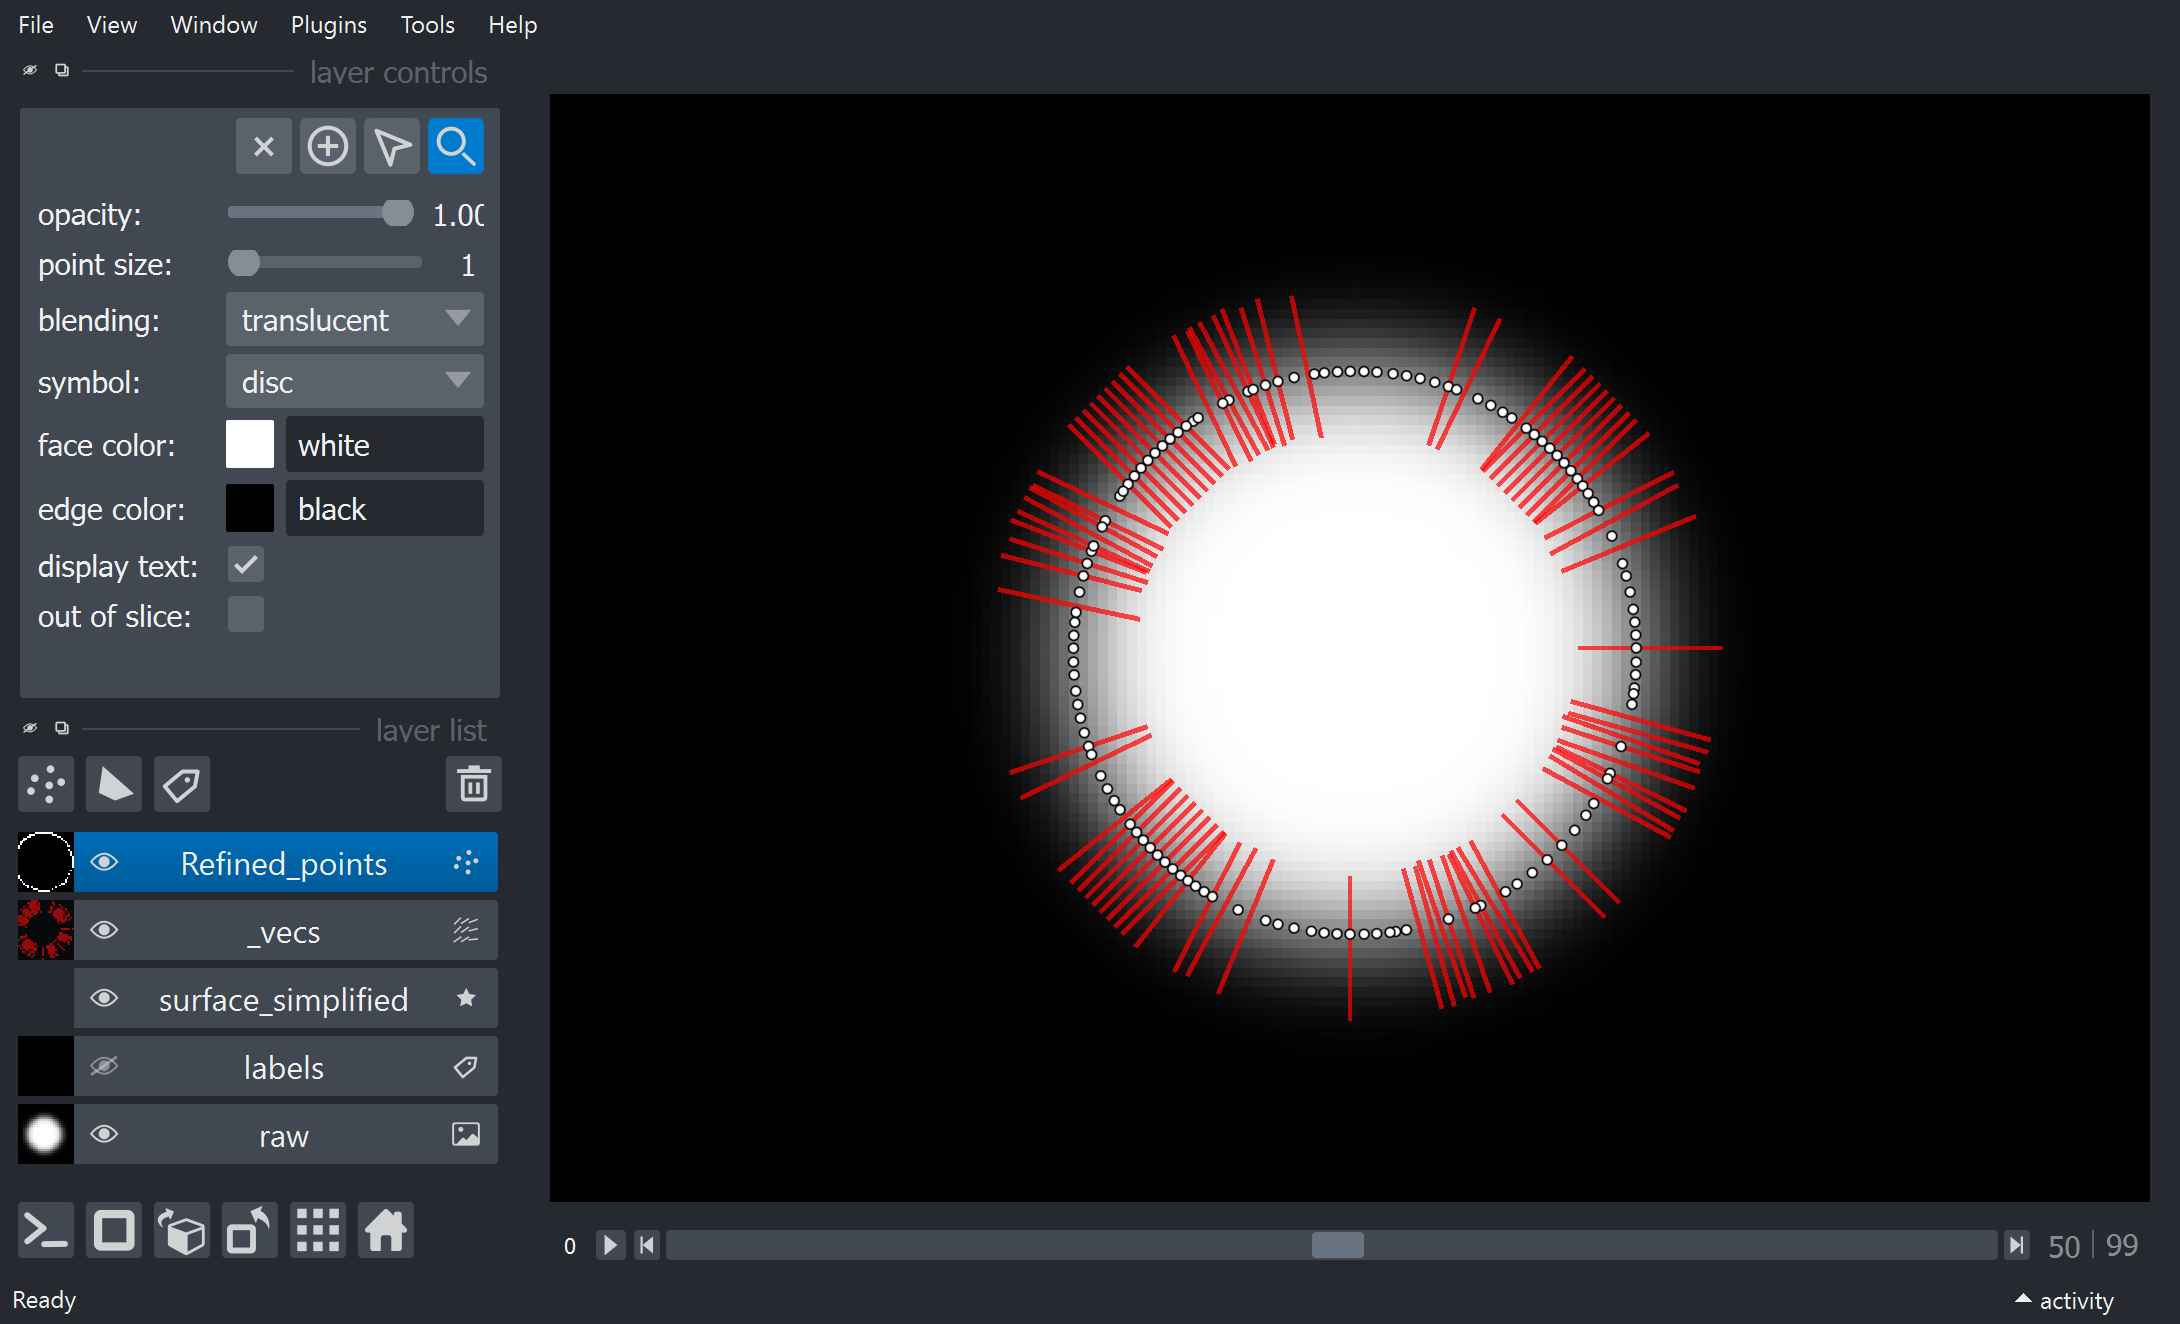

In [23]:
viewer.add_points(traced_points[0], **traced_points[1])
napari.utils.nbscreenshot(viewer)

Or in 3D:

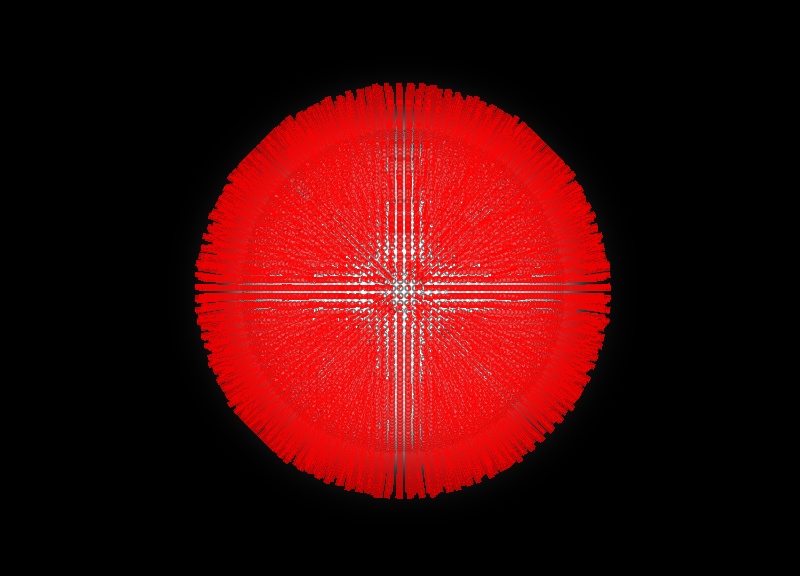

In [24]:
viewer2 = napari.Viewer(ndisplay=3)
viewer2.add_image(image)
viewer2.add_points(traced_points[0], **traced_points[1])
viewer2.add_vectors(trace_vectors[0])
napari.utils.nbscreenshot(viewer2, canvas_only=True)